# Fig.3, Bifurcation Graph Iapp-Ko

## Importing useful functions and packages

In [1]:
### Importing packages and functions
import sys
import os
#### This should be set as the path of auto in your own computer, if you didn't add the path to your bashrc file
# os.environ['AUTO_DIR'] = '/auto-07p'
import numpy as np
import pylab, json, sympy, scipy
import matplotlib
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc
from copy import copy
### Add path to functions
sys.path.insert(1, './functions')
from m_generic_neuron_from_json import generic_neuron_from_json
from m_generic_neuron_from_json import load_mod
### Something for sympy to work with python 3
from sympy import S
from operator import itemgetter
### to create temp files in every run
import contextlib
import tempfile
import shutil
### Import auto stuff
import autoutils
import auto

In [2]:
## Hack for auto to work
%load_ext autoreload
%autoreload 2

In [3]:
# This is to run auto related stuff in a temporary folder (files are created in every run, and are not needed later)
@contextlib.contextmanager
def TemporaryDirectory(suffix="", prefix="tmp", dir=None):
    name = tempfile.mkdtemp(suffix, prefix, dir)
    try:
        yield name
    finally:
        shutil.rmtree(name)

In [4]:
# This is to save the lines of the bifurcation diagram
import pickle
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

dir_sims='./Data/'

In [5]:
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto, and runs an ode to find the steady state
def get_expressions_and_ss(neuron_snap,bifpar,autobifpart):
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    adlinsys = [str(k) for k in
                (sympy.S("lam")*sympy.eye(len(advar))-sympy.Matrix(J).T)*sympy.Matrix(advar)]
    prcnorm=str((sympy.Matrix(sympy.S(advar)).T*sympy.Matrix(sympy.S(rhs)))[0,0] - sympy.S("dotZF/period"))
    spikecriterion = [str(S(k).subs([(i,"{}_left".format(i)) for i in var]))
                      for j,k in zip(var,rhs) if j=="v"]
    ##############################333##############################333##############################333
    ############## # Running model with ode, to find the steady state                  ###########333#
    ##############################333##############################333##############################333
    neuron_fromgen_4sim.changing_pars(bifpar,strIapp=strIapp)
    # Constant input stimuli
    I_exp1 = lambda t: 0 if t<0 else autobifpart[strIapp]
    t=np.linspace(0, 1000, int(1000.0/0.01))
    # Running ODE
    s_results, v_results=neuron_fromgen_4sim.stimulate_neuron(t,neuron_fromgen_4sim.current_state,I_exp1)
    inivals = ([float(v_results[:,s_results.index(j)][-1]) for j in var])
    return var,rhs,spikecriterion,J,inivals

# Defining setup for the continuations

### Defining neuron model

In [6]:
## Loading neuron model (file in the cfg folder)
model_name_p='MTM_W_sPNaS_sICD'
model_name_p0='MTM_W_sPNaS_snapshot_p0'
model_name_pp='MTM_W_sPNaS_snapshot_pp'

### How is the applied current parameter called
strIapp='I_app'
### creating a class neuron from m_generic_neuron_from_json that clasifies the expressions for ode
neuron_snap_p=generic_neuron_from_json(model_name_p+'.json',strIapp=strIapp)
neuron_snap_p0=generic_neuron_from_json(model_name_p0+'.json',strIapp=strIapp)
neuron_snap_pp=generic_neuron_from_json(model_name_pp+'.json',strIapp=strIapp)

In [7]:
### Check if parameters are the same in all models...
for ipar_s in neuron_snap_pp.p.keys():
    if ipar_s in neuron_snap_p.p.keys():
        if neuron_snap_pp.p[ipar_s]!=neuron_snap_p.p[ipar_s]:
            print(ipar_s+' is different in big model')
    else:
        print(ipar_s+' not in big model')
        
for ipar_s in neuron_snap_pp.p.keys():
    if ipar_s in neuron_snap_p0.p.keys():
        if neuron_snap_pp.p[ipar_s]!=neuron_snap_p0.p[ipar_s]:
            print(ipar_s+' is different in pump0 model')
    else:
        print(ipar_s+' not in pump0 model')
        
#         neuron.p[ipar_s]=ref_sim.c_neuron.p[ipar_s]

K_o not in big model
Na_i not in big model
K_i not in big model


### Defining bifurcation parameters


In [8]:
## Defining Bifurcation parameters.. (In our case I_app and Ko)
bifpar={}
autobifpart={}
I_app=-5.0
K_o=5.0
bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
autobifpart[strIapp]=I_app
bifpar['K_o'] = ['('+str(K_o)+"*mM)"]
autobifpart['K_o']=K_o

## Setting parameters for the snapshot model as the initial conditions of the big model
i_sn=[ii for ii,i_s in enumerate(neuron_snap_p.s_state_vars) if i_s=='K_i'][0]
K_i=neuron_snap_p.current_state[i_sn]
bifpar['K_i'] = ['('+str(K_i)+"*mM)"]
autobifpart['K_i']=K_i


i_sn=[ii for ii,i_s in enumerate(neuron_snap_p.s_state_vars) if i_s=='Na_i'][0]
Na_i=neuron_snap_p.current_state[i_sn]
bifpar['Na_i'] = ['('+str(Na_i)+"*mM)"]
autobifpart['Na_i']=Na_i


cc=0
for j in neuron_snap_p.s_currents:
    if  'i_p'==j:
        i_p_i=neuron_snap_p.neuron_currents(neuron_snap_p.current_state)[cc]
    cc+=1

if i_p_i>0:
    x_neuron=copy(neuron_snap_pp)
    model_name=model_name_pp
else:
    x_neuron=copy(neuron_snap_p0)
    model_name=model_name_p0


In [9]:
### Using the function above to obtain the expressions and the steady state from the model (needed to run AUTO)
var,rhs,spikecriterion,J,inivals=get_expressions_and_ss(x_neuron,bifpar,autobifpart)

# Running AUTO (to continue on the bifpar space)

### Continuing the steady state forward to find the saddle node and the hopf bifurcations

In [10]:
import autoutils
import auto
cwd_nonTemp = os.getcwd()
with TemporaryDirectory(suffix="trial0") as t:
    os.chdir(t)
    ##############################333##############################333##############################333
    ##############                # Writing Auto readable files                   ###########333#
    ##############################333##############################333##############################333
    automodelname='autoOrbitSpike_'+model_name
    unames,pnames= autoutils.writeFP(automodelname,
        bifpar=autobifpart, rhs=rhs, var=var,
        bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
        ic=[])
    #############################################################
    ##### Using AUTO to Continue steady state
    # Continuing Forward (ds>0) in I_app
    r1_fwd= auto.run(inivals, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=[strIapp], ISP=1,ILP=1, ISW = 1, SP=['LP','HB','BP'],
        PAR=autobifpart, ITNW=17, NWTN=13, NMX = 200000,NPR=10000,
        DS= 1 * 1e-3, DSMAX= 1 * 1e-2, STOP=['HB'],
        UZSTOP= {})

## Making sure the original path is restored
os.chdir(cwd_nonTemp)
###### HEre we store the continuation in np arrays vectors
v_s_par=[strIapp]

v_s_var=[]
for i in range(len(unames)):
    v_s_var.append(unames[i+1])

m_res_par=[]
for i_s in v_s_par:
    m_res_par.append(r1_fwd[i_s])

m_res_statev=[]
for i_s in v_s_var:
    m_res_statev.append(r1_fwd[i_s])
    
m_res_stab = np.array([i['PT'] for i in r1_fwd[0]])

initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -5.0, 2: 5.0, 3: 150.0, 4: 10.0, 11: 0}
For fix point continuation AUTO requires:
4=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1  6429  LP    2   1.44090E+00   6.41086E+01  -6.41009E+01   5.95141E-02   2.63424E-02   9.91525E-01
   1     1        3  -2.93817E+01   5.21076E+01  -5.20998E+01   2.63681E-01   1.85199E-01   8.45687E-01
   1  2197  LP    4  -5.09216E+01   4.86335E+01  -4.86265E+01   3.51685E-01   2.74917E-01 

In [11]:
### Extracting sadle node and Hopf from continuation, to continue them later
sn0=r1_fwd.getLabel('LP')[0]
s1HB = r1_fwd('HB')[0]

### Continuing the limit cycle that emerges at the hopf point -> backwards to find the limit cycle onset (period>>0).

In [12]:
################# continuing orbit #######################
### Starting from the hopf point backwards (ds<0) in I_app until the onset of spiking is reached..
with TemporaryDirectory(suffix="trial0") as t:
    os.chdir(t)
    ##############################333##############################333##############################333
    ##############                # Writing Auto readable files                   ###########333#
    ##############################333##############################333##############################333
    automodelname='autoOrbitSpike_'+model_name
    unames,pnames= autoutils.writeFP(automodelname,
        bifpar=autobifpart, rhs=rhs, var=var,
        bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
        ic=[])
    #############################################################
    ##### Using AUTO to Continue limit cycle emerging at the hopf bifurcation
    # Continuing Forward (ds>0) in I_app
    r1_period0 = auto.run(s1HB, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=['I_app','period'], ILP=1, ISW=1,IPS=2,
        ITNW=17, NWTN=13, NMX=100000, NPR=3000,
        DS=-1e-2, DSMIN=-1e-3, DSMAX=-1e-1, NTST= 300,
        SP=['BT','LP','HB','BP','CP'],
        UZSTOP={'period': 100})## Note that the bigger the period the more precise is the limit cycle onset position
    
os.chdir(cwd_nonTemp)
############ Extracting info from AUTO object
#############################################################
##### Finding limit cycle onset (period>>0)
try:
    lc_onset = r1_period0.getLabel('LP')[0]
except:
    pass
try:
    lc_onset = r1_period0.getLabel('UZ')[0]
except:
    pass


###### HEre we extract the information AUTO calculated and store it in numpy arrays     
m_res_par_lc=[]
for i_s in v_s_par:
    m_res_par_lc.append(r1_period0[i_s])

m_res_statev_lc=[]
for i_s in v_s_var:
    m_res_statev_lc.append(r1_period0['MAX '+i_s])
    
###### Finding stability of limit cycles
m_res_lc_stab = np.array([i['PT'] for i in r1_period0[0]])

initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -5.0, 2: 5.0, 3: 150.0, 4: 10.0, 11: 0}
For fix point continuation AUTO requires:
4=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM        MAX v        MAX n_K       MAX m_Na      MAX h_Na       period    
  15     3  BP   25   9.97206E+02   3.80501E+01  -3.80251E+01   6.04615E-01   6.00095E-01   1.42606E-01   9.62515E-01
  15  3000       26   6.97906E+02   4.09429E+01  -2.85446E+01   5.93906E-01   7.89602E-01   1.61960E-01   9.93643E-01
  15  6000       27   3.97988E+02   4.54165E+01 

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


In [13]:
### Extracting limit cycle onset
lc=copy(lc_onset)

## Plot initial continuation

/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


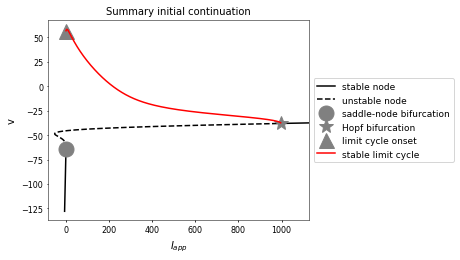

In [14]:
###################################
### Plot initial bifurcation ######
###################################
### Importing the format for figures..
P= json.load(open("cfg/PLOSmpl.json")) # import plot parameter
matplotlib.rcParams.update([(j,k) for (j,k) in P.items()
                            if j in matplotlib.rcParams.keys()])

fig_wide=matplotlib.rcParams["figure.figsize"][0]
fig_height=matplotlib.rcParams["figure.figsize"][1]*0.7
fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height*1.3))


# Nodes: plot stable and unstable nodes. to do this, set stable/unstable parts to NaN.
un, sn = np.copy(m_res_par[0]), np.copy(m_res_par[0])
sn[m_res_stab>0] = np.nan
un[m_res_stab<0] = np.nan

## Limit cycles: plot stable and unstable limit cycles (lc)
slc,ulc = np.copy(m_res_par_lc[0]), np.copy(m_res_par_lc[0])
slc[m_res_lc_stab>0] = np.nan
ulc[m_res_lc_stab<0] = np.nan


resol_cont=20
axpl = plt.subplot2grid((20,20), (0, 0), colspan=18,rowspan=18)
axpl.plot(sn[::resol_cont],m_res_statev[v_s_var=='v'][::resol_cont],c='k',label='stable node')
axpl.plot(un[::resol_cont],m_res_statev[v_s_var=='v'][::resol_cont],'--',c='k',label='unstable node')

axpl.plot(r1_fwd.getLabel('LP')[0][strIapp],r1_fwd.getLabel('LP')[0]['v'],'o',markersize=15,color='grey',label='saddle-node bifurcation')
axpl.plot(r1_fwd.getLabel('HB')[0][strIapp],r1_fwd.getLabel('HB')[0]['v'],'*',markersize=15,color='grey',label='Hopf bifurcation')
axpl.plot(lc[strIapp],max(lc['v']),'^',markersize=15,color='grey',label='limit cycle onset')

axpl.plot(slc[::resol_cont],m_res_statev_lc[v_s_var=='v'][::resol_cont],color='r',label='stable limit cycle')
axpl.set_xlim(r1_fwd.getLabel('LP')[1][strIapp]-30,r1_fwd.getLabel('HB')[0][strIapp]+130)


axpl.set_xlabel(r'$I_{app}$')
axpl.set_ylabel(v_s_var[v_s_var=='v'])
axpl.set_title('Summary initial continuation')

axpl.legend(loc='center left', bbox_to_anchor=(1, 0.5))



# Continuing the saddle node bifurcation in the plane Ko-Iapp

In [15]:
################# Find Bistability in the concs space ######################
############################################################################
############################################################################
############# Define: How precise is exploration.. #########################
conc_lim=[3,28]# Boundaries for concentration space
d_conc_resol=1# Resolution of the concentration grid
K_vv=scipy.linspace(conc_lim[0],conc_lim[1],(conc_lim[1]-conc_lim[0])/d_conc_resol).tolist()
ds_resol=1e-4
#######################################################################
#######################################################################
##############      K++ conc           #############################
##### Saddle node
### First continuing the sn in the Ko-I_app plane..
sn_t0=copy(sn0)
with TemporaryDirectory(suffix="trial0") as t:
    os.chdir(t)
    ##############################333##############################333##############################333
    ##############                # Writing Auto readable files                   ###########333#
    ##############################333##############################333##############################333
    automodelname='autoOrbitSpike_'+model_name
    unames,pnames= autoutils.writeFP(automodelname,
        bifpar=autobifpart, rhs=rhs, var=var,
        bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
        ic=[])
    # Continuing Forward (ds>0)
    r_ko_sn_f= auto.run(sn_t0, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=['K_o','I_app'], ISP=1, ILP=1, ISW=2, SP=['LP','HB','BP'],
        ITNW=7, NWTN=3, NMX=500000, NPR=500000,
        DS= ds_resol, DSMAX= ds_resol*10, UZR= {"K_o":K_vv[:]},
        UZSTOP= {'K_o': [K_vv[0]-0.1, K_vv[-1]+0.1]})
    # Continuing Backward (ds<0)
    r_ko_sn_b= auto.run(sn_t0,  e=automodelname,
            c=automodelname, parnames= pnames, unames=unames,
            ICP=['K_o','I_app'], ISP=1, ILP=1, ISW=2, SP=['LP','HB','BP'],
            ITNW=7, NWTN=3, NMX=500000, NPR=500000,
            DS= -1* ds_resol, DSMAX= -1 * ds_resol*10, UZR= {"K_o":K_vv[:]},
            UZSTOP= {'K_o': [K_vv[0]-0.1, K_vv[-1]+0.1]})
    

os.chdir(cwd_nonTemp)

###### HEre we store the continuation in np arrays vectors
v_s_par=['K_o','I_app']
            
m_res_par_sn_KoIapp=[]
for i_s in v_s_par:
    m_res_par_sn_KoIapp.append(np.concatenate([r_ko_sn_b[i_s],r_ko_sn_f[i_s]]))

m_res_statev_sn_KoIapp=[]
for i_s in v_s_var:
    m_res_statev_sn_KoIapp.append(np.concatenate([r_ko_sn_b[i_s],r_ko_sn_f[i_s]]))

initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -5.0, 2: 5.0, 3: 150.0, 4: 10.0, 11: 0}
For fix point continuation AUTO requires:
4=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o


/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ...

  BR    PT  TY  LAB      K_o         L2-NORM          v            n_K           m_Na          h_Na         I_app     
   2    98  UZ   25   5.08333E+00   6.41207E+01  -6.41130E+01   5.94041E-02   2.62803E-02   9.91551E-01   1.39824E+00
   2  1253  UZ   26   6.12500E+00   6.42513E+01  -6.42436E+01   5.82325E-02   2.56207E-02   9.91826E-01   9.17697E-01
   2  2376  UZ   27   7.16667E+00   6.43530E+01  -6.43454E+01   5.73330E-02   2.51170E-02   9.92034E-01   5.13485E-01
   2  3478  UZ   28   8.20833E+00   6.44357E+01  -6.44280E+01   5.66111E-02   2.47145E-02   9.92199E-01   1.64661E-01
   2  4567  UZ   29   9.25000E+00   6.45048E+01  -6.44972E+01   5.60129E-02   2.43822E-02   9.92335E-01  -1.42132E-01
   2  5646  U

# Continuing the limit cycle onset in the Ko-I_app-period space

In [16]:
#############################################################################
#####Limit cycle onset (period>>0)
#############################################################################
lc_t0=copy(lc)
nmx=1000
with TemporaryDirectory(suffix="trial0") as t:
    os.chdir(t)
    ##############################333##############################333##############################333
    ##############                # Writing Auto readable files                   ###########333#
    ##############################333##############################333##############################333
    automodelname='autoOrbitSpike_'+model_name
    unames,pnames= autoutils.writeFP(automodelname,
        bifpar=autobifpart, rhs=rhs, var=var,
        bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
        ic=[])
    # Continuing Backward (ds<0)
    r_ko_lc_b = auto.run(lc_t0,  e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=['K_o','I_app','period'],
        ILP=1,
        ISW=1,
        IPS=2,
        ITNW=17, NWTN=13, NMX=nmx, NPR=1000, #Not sure if needed: PAR=autobifpar,
        DS= -1 * ds_resol*100, DSMAX= -1 * ds_resol*10*100, UZR= {"K_o":K_vv[:]}, #IID = 5, RL1=0.58, EPSL = 1e+1, EPSU = 1e+1, EPSS = 10, NTST = 500,
        UZSTOP= {'K_o': [K_vv[0]-0.1,K_vv[-1]+0.1]}
        )
    # Continuing Forward (ds>0)
    r_ko_lc_f = auto.run(lc_t0, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=['K_o','I_app','period'],
        ILP=1,
        ISW=1,
        IPS=2,
        ITNW=17, NWTN=13, NMX=nmx, NPR=1000, #Not sure if needed: PAR=autobifpar,
        DS= ds_resol*100, DSMAX= ds_resol*10*100, UZR= {"K_o":K_vv[:]},#UZR defines the values to be stored when the continuation passes over them
        UZSTOP= {'K_o': [K_vv[0]-0.1,K_vv[-1]+0.1]}
        )
    
os.chdir(cwd_nonTemp)


###### HEre we store the continuation in np arrays vectors
v_s_par=['K_o','I_app','period']
            
m_res_par_lc_KoIapp=[]
for i_s in v_s_par:
    m_res_par_lc_KoIapp.append(np.concatenate([r_ko_lc_b[i_s],r_ko_lc_f[i_s]]))

m_res_statev_lc_KoIapp=[]
for i_s in v_s_var:
    m_res_statev_lc_KoIapp.append(np.concatenate([r_ko_lc_b['MAX '+i_s],r_ko_lc_f['MAX '+i_s]]))

initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -5.0, 2: 5.0, 3: 150.0, 4: 10.0, 11: 0}
For fix point continuation AUTO requires:
4=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ...

  BR    PT  TY  LAB      K_o         L2-NORM        MAX v        MAX n_K       MAX m_Na      MAX h_Na       I_app         period    
  15    24  UZ   30   4.04162E+00   6.69305E+01   5.66343E+01   6.36772E-01   9.99499E-01   9.99161E-01   2.02973E+00   1.00000E+02
  15    45  UZ   31   3.00000E+00   6.76076E+01   5.59027E+01   6.28765E-01   9.99249E-01   1.00155E+00   2.80337E+00   1.00000E+02
  15  

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


  15   215  UZ   41   1.65417E+01   5.74528E+01   5.64611E+01   6.90626E-01   9.99582E-01   9.57999E-01  -7.92764E+00   1.00000E+02
  15   269  UZ   42   1.75833E+01   5.62838E+01   5.55596E+01   6.92764E-01   9.99691E-01   9.44329E-01  -1.30280E+01   1.00000E+02
  15   426  UZ   43   1.96667E+01   5.42307E+01   5.24893E+01   6.99387E-01   9.99430E-01   9.10006E-01  -2.98117E+01   1.00000E+02
  15   433  UZ   44   1.97486E+01   5.41796E+01   5.28416E+01   6.94870E-01   9.99486E-01   9.08942E-01  -3.04229E+01   1.00000E+02
  15   651  UZ   45   2.17500E+01   5.25436E+01   4.96335E+01   7.03520E-01   9.99399E-01   8.68946E-01  -5.53300E+01   1.00000E+02
  15   694  UZ   46   2.20209E+01   5.23051E+01   4.91385E+01   7.01760E-01   9.99456E-01   8.61967E-01  -6.00451E+01   1.00000E+02
  15   789  UZ   47   2.27917E+01   5.18307E+01   4.82601E+01   7.04845E-01   9.99098E-01   8.47247E-01  -7.05856E+01   1.00000E+02
  15   802  UZ   48   2.28023E+01   5.17565E+01   4.76635E+01   7.04448E-01 

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


# Finding hopf bifurcation (depolarization block) in Ko-Iapp space


In [17]:
s_x=1;s_y=0
v_xx_flc=np.array(m_res_par_lc_KoIapp[s_x])
v_yy_flc=np.array(m_res_par_lc_KoIapp[s_y])


In [18]:
m_res_par_HF=[]
m_res_statev_HF=[]
### Getting Hobf with a loop
cc_hof=0
for iii in np.concatenate([range(len(v_yy_flc))[::int(len(v_yy_flc)/10)],np.array([range(len(v_yy_flc))[-1]])]):
    bifpar['K_o'] = ['('+"{:.6f}".format(v_yy_flc[iii])+"*mM)"]
    I_api=v_xx_flc[iii]-5.0
    bifpar["I_app"] = ['('+"{:.6f}".format(I_api)+"* uA/cm2"]
    autobifpart["I_app"]=float("{:.6f}".format(I_api))
    autobifpart['K_o']=float("{:.6f}".format(v_yy_flc[iii]))
    ### Get inivals for each parameter combination
    var,rhs,spikecriterion,J,inivals=get_expressions_and_ss(x_neuron,bifpar,autobifpart)
    ### Run continuation
    with TemporaryDirectory(suffix="trial0"+str(iii)) as t:
        os.chdir(t)
        ##############################333##############################333##############################333
        ##############                # Writing Auto readable files                   ###########333#
        ##############################333##############################333##############################333
        automodelname='autoOrbitSpike_'+model_name
        unames,pnames= autoutils.writeFP(automodelname,
            bifpar=autobifpart, rhs=rhs, var=var,
            bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
            ic=[])
        #############################################################
        ##### Using AUTO to Continue steady state
        # Continuing Forward (ds>0) in I_app
        r1_fwd_hf_Ko= auto.run(inivals, e=automodelname,
            c=automodelname, parnames= pnames, unames=unames,
            ICP=[strIapp], ISP=1,ILP=1, ISW = 1, SP=['LP','HB','BP'],
            PAR=autobifpart, ITNW=17, NWTN=13, NMX = 250000,NPR=10000,
            DS= 1 * 1e-3, DSMAX= 1 * 1e-2, STOP=['HB'],
            UZSTOP= {})

    os.chdir(cwd_nonTemp)
    
    try:
        sHB_Ko = r1_fwd_hf_Ko('HB')[0]
        m_res_par_HF.append([[sHB_Ko['K_o']],[sHB_Ko['I_app']]])
        m_res_statev_HF.append(sHB_Ko.coordarray)
        
    except:
        pass
    
    cc_hof+=1
    print('Done with..'+str(cc_hof)+'/'+str(len(np.concatenate([range(len(v_yy_flc))[::int(len(v_yy_flc)/10)],np.array([range(len(v_yy_flc))[-1]])]))))


initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -3.521176, 2: 5.0, 3: 150.0, 4: 10.0, 11: 0}
For fix point continuation AUTO requires:
4=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1  4996  LP    2   1.44090E+00   6.41086E+01  -6.41009E+01   5.95141E-02   2.63424E-02   9.91525E-01
   1     1        3  -4.36013E+01   5.03349E+01  -5.03275E+01   3.07885E-01   2.28804E-01   7.77479E-01
   1   764  LP    4  -5.09216E+01   4.86335E+01  -4.86265E+01   3.51685E-01   2.74917

   1     1        3  -2.75602E+01   5.44006E+01  -5.43924E+01   2.10318E-01   1.36569E-01   9.07599E-01
   1     2        4  -1.27412E+02   4.91693E+01  -4.91622E+01   3.37805E-01   2.59992E-01   7.22256E-01
   1  7441  LP    5  -2.01578E+02   4.50549E+01  -4.50486E+01   4.44039E-01   3.81700E-01   4.79840E-01
   1     3        6  -1.76123E+02   4.32426E+01  -4.32360E+01   4.89045E-01   4.38578E-01   3.69948E-01
   1     4        7  -7.61449E+01   4.11948E+01  -4.11874E+01   5.37272E-01   5.03183E-01   2.61688E-01
   1     5        8   2.38472E+01   3.99485E+01  -3.99403E+01   5.64983E-01   5.42041E-01   2.07450E-01
   1     6        9   1.23842E+02   3.89529E+01  -3.89439E+01   5.86149E-01   5.72567E-01   1.70839E-01
   1     7       10   2.23839E+02   3.80895E+01  -3.80798E+01   6.03783E-01   5.98542E-01   1.43712E-01
   1  8478  HB   11   3.08543E+02   3.74248E+01  -3.74144E+01   6.16900E-01   6.18169E-01   1.25545E-01
   1     8       12   3.23833E+02   3.73098E+01  -3.72993E+01   

   1     8       11   2.36143E+01   3.83958E+01  -3.83863E+01   5.97606E-01   5.89388E-01   1.52862E-01
   1     9       12   1.23610E+02   3.74198E+01  -3.74094E+01   6.16997E-01   6.18315E-01   1.25417E-01
   1  1654  HB   13   1.40052E+02   3.72702E+01  -3.72597E+01   6.19892E-01   6.22682E-01   1.21639E-01
   1    10       14   2.23598E+02   3.65458E+01  -3.65345E+01   6.33626E-01   6.43554E-01   1.04826E-01
   1    11       15   3.23595E+02   3.57406E+01  -3.57284E+01   6.48332E-01   6.66176E-01   8.88021E-02
   1    12       16   4.23592E+02   3.49857E+01  -3.49726E+01   6.61590E-01   6.86782E-01   7.60320E-02
   1    13       17   5.23590E+02   3.42697E+01  -3.42558E+01   6.73701E-01   7.05752E-01   6.56788E-02
   1    14       18   6.23587E+02   3.35849E+01  -3.35700E+01   6.84870E-01   7.23341E-01   5.71752E-02
   1    15       19   7.23585E+02   3.29258E+01  -3.29101E+01   6.95244E-01   7.39731E-01   5.01178E-02
   1    16       20   8.23583E+02   3.22886E+01  -3.22720E+01   

   1    15       19   4.45730E+02   3.40149E+01  -3.40006E+01   6.77904E-01   7.12361E-01   6.23653E-02
   1    16       20   5.45727E+02   3.32865E+01  -3.32713E+01   6.89612E-01   7.30828E-01   5.38523E-02
   1    17       21   6.45725E+02   3.25875E+01  -3.25714E+01   7.00428E-01   7.47933E-01   4.68773E-02
   1    18       22   7.45722E+02   3.19134E+01  -3.18963E+01   7.10482E-01   7.63838E-01   4.11058E-02
   1    19       23   8.45720E+02   3.12607E+01  -3.12427E+01   7.19872E-01   7.78668E-01   3.62899E-02
   1    20       24   9.45718E+02   3.06268E+01  -3.06078E+01   7.28677E-01   7.92523E-01   3.22419E-02
   1    21       25   1.04572E+03   3.00095E+01  -2.99896E+01   7.36960E-01   8.05486E-01   2.88169E-02
   1    22       26   1.14571E+03   2.94072E+01  -2.93864E+01   7.44775E-01   8.17627E-01   2.59013E-02
   1    23       27   1.24571E+03   2.88185E+01  -2.87968E+01   7.52166E-01   8.29006E-01   2.34056E-02
   1    24       28   1.34571E+03   2.82422E+01  -2.82195E+01   

gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1     1        2  -6.48227E+01   6.68173E+02  -6.68172E+02   2.75501E-59   2.27198E-67   1.00000E+00
   1     2        3  -5.45067E+01   5.68707E+02  -5.68706E+02   1.21104E-49   1.42010E-56   1.00000E+00
   1     3        4  -4.41906E+01   4.69240E+02  -4.69239E+02   5.12615E-40   8.84305E-46   1.00000E+00
   1     4        5  -3.38746E+01   3.69774E+02  -3.69773E+02   2.04652E-30   5.46721E-35   1.00000E+00
   1     5        6  -2.35585E+01   2.70308E+02  -2.70306E+02   7.36984E-21   3.32467E-24   1.00000E+00
   1     6        7  -1.32425E+01   1.70843E+02  -1.70840E+02   2.10303E-11   1.91417E-13   1.000

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


Done with..10/12
initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -98.395584, 2: 23.987192, 3: 150.0, 4: 10.0, 11: 0}
For fix point continuation AUTO requires:
4=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1     1        2  -8.80831E+01   8.91079E+02  -8.91079E+02   6.20335E-81   1.44386E-91   1.00000E+00
   1     2        3  -7.77670E+01   7.91613E+02  -7.91612E+02   2.86629E-71   9.06017E-81   1.00000E+00
   1     3        4  -6.74510E+01   6.92147E+02  -6.92146E+02

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


Done with..11/12
initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -99.102915, 2: 24.028876, 3: 150.0, 4: 10.0, 11: 0}
For fix point continuation AUTO requires:
4=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1     1        2  -8.87904E+01   8.97857E+02  -8.97857E+02   1.36084E-81   2.65296E-92   1.00000E+00
   1     2        3  -7.84743E+01   7.98391E+02  -7.98390E+02   6.29461E-72   1.66484E-81   1.00000E+00
   1     3        4  -6.81583E+01   6.98924E+02  -6.98924E+02

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


Done with..12/12


### Running one more time with a higher Ko to make the hopf line complete

In [19]:
os.chdir(cwd_nonTemp)
#### One more hopf to make the hopf line complete
bifpar['K_o'] = ['('+"{:.6f}".format(v_yy_flc[iii]+5.0)+"*mM)"]
I_api=v_xx_flc[iii]-7.0
bifpar["I_app"] = [str(I_api)+"* uA/cm2"]
autobifpart["I_app"]=I_api
autobifpart['K_o']=v_yy_flc[iii]+5.0
var,rhs,spikecriterion,J,inivals=get_expressions_and_ss(x_neuron,bifpar,autobifpart)
with TemporaryDirectory(suffix="trial0") as t:
    os.chdir(t)
    ##############################333##############################333##############################333
    ##############                # Writing Auto readable files                   ###########333#
    ##############################333##############################333##############################333
    automodelname='autoOrbitSpike_'+model_name
    unames,pnames= autoutils.writeFP(automodelname,
        bifpar=autobifpart, rhs=rhs, var=var,
        bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
        ic=[])
    #############################################################
    ##### Using AUTO to Continue steady state
    # Continuing Forward (ds>0) in I_app
    r1_fwd_hf_Ko= auto.run(inivals, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=[strIapp], ISP=1,ILP=1, ISW = 1, SP=['LP','HB','BP'],
        PAR=autobifpart, ITNW=17, NWTN=13, NMX = 250000,NPR=10000,
        DS= 1 * 1e-3, DSMAX= 1 * 1e-2, STOP=['HB'],
        UZSTOP= {})
    
os.chdir(cwd_nonTemp)
sHB_Ko = r1_fwd_hf_Ko('HB')[0]
m_res_par_HF.append([[sHB_Ko['K_o']],[sHB_Ko['I_app']]])
m_res_statev_HF.append(sHB_Ko.coordarray)

initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -101.102915005, 2: 29.028875854, 3: 150.0, 4: 10.0, 11: 0}
For fix point continuation AUTO requires:
4=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1     1        2  -9.07904E+01   9.12557E+02  -9.12556E+02   5.06882E-83   6.72948E-94   1.00000E+00
   1     2        3  -8.04743E+01   8.13090E+02  -8.13090E+02   2.34994E-73   4.22363E-83   1.00000E+00
   1     3        4  -7.01583E+01   7.13624E+02  -7.13623E+02   1.07084

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


In [20]:
m_res_par_HF0=np.concatenate(m_res_par_HF,axis=1)

# Result: Continuation of the Hopf, saddle node and the limit cycle onset in the Ko-Iapp plane

In [21]:
# ### Saving continuation...
### If it is meant to save continuations only...

d_Bif_graph_data={}
d_Bif_graph_data['Bif_parameters']=v_s_par
d_Bif_graph_data['state_pars']=v_s_var
d_Bif_graph_data['saddle_node_par']=m_res_par_sn_KoIapp
d_Bif_graph_data['saddle_node_var']=m_res_statev_sn_KoIapp
d_Bif_graph_data['limit_cycle_onset_par']=m_res_par_lc_KoIapp
d_Bif_graph_data['limit_cycle_onset_var']=m_res_statev_lc_KoIapp
d_Bif_graph_data['Hopf_par']=m_res_par_HF0
d_Bif_graph_data['Hopf_var']=m_res_statev_HF

dir_folder='./Data/'
file_n='Bifurcation_Graph_Iapp_Ko_'+model_name

save_obj(d_Bif_graph_data,dir_folder+file_n)

In [22]:

# ### If it is meant to load only...

# dir_folder='./Data/'
# file_n='Bifurcation_Graph_Iapp_Ko_'+model_name

# f=open(dir_folder+file_n+'.pkl', 'rb')
# d_Bif_graph_data=pickle.load(f)

# v_s_par=d_Bif_graph_data['Bif_parameters']
# v_s_var=d_Bif_graph_data['state_pars']
# m_res_par_sn_KoIapp=d_Bif_graph_data['saddle_node_par']
# m_res_statev_sn_KoIapp=d_Bif_graph_data['saddle_node_var']
# m_res_par_lc_KoIapp=d_Bif_graph_data['limit_cycle_onset_par']
# m_res_statev_lc_KoIapp=d_Bif_graph_data['limit_cycle_onset_var']
# m_res_par_HF0=d_Bif_graph_data['Hopf_par']
# m_res_statev_HF=d_Bif_graph_data['Hopf_var']

/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


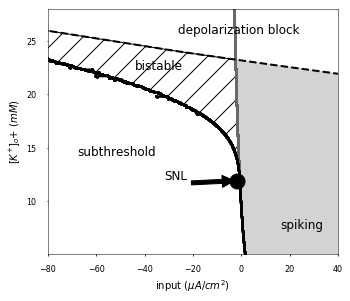

In [23]:
###################################
### Plot bifurcation diagram ######
###################################
### Importing the format for figures..
import json
P= json.load(open("cfg/PLOSmpl.json")) # import plot parameter
matplotlib.rcParams.update([(j,k) for (j,k) in P.items()
                            if j in matplotlib.rcParams.keys()])


from scipy.interpolate import interp1d
matplotlib.rcParams['lines.linewidth']=2.0

plt.close("all")
fig01 = plt.figure(facecolor="1")
axpl = plt.subplot2grid((1,1), (0, 0))


xlim=[-80,40]
ylim=[5.1,28]
axpl.set_xlim(xlim)
axpl.set_ylim(ylim)

s_x=1;s_y=0
##### plot saddle node bifurcation, hopf and limit cycle onset (HOM)
axpl.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],'o',markersize=2,color='dimgray')
axpl.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],'o',markersize=2,color=[0,0,0])
axpl.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',color=[0,0,0])

##### fill areas in the different regions
a=m_res_par_lc_KoIapp[s_x]
b=m_res_par_sn_KoIapp[s_y]
bx=m_res_par_sn_KoIapp[s_x]
c=m_res_par_HF0[s_x]
cy=m_res_par_HF0[s_y]
f1x = interp1d(m_res_par_sn_KoIapp[s_y][bx.argsort()],bx[bx.argsort()],fill_value=min(m_res_par_sn_KoIapp[s_x]), bounds_error=False)
f2x = interp1d(m_res_par_lc_KoIapp[s_y][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
f3x = interp1d(m_res_par_HF0[s_y][c.argsort()],c[c.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
yy=m_res_par_sn_KoIapp[s_x][b.argsort()]
yy2=np.minimum(f3x(b[b.argsort()]),yy)
axpl.fill_betweenx(b[b.argsort()],f2x(b[b.argsort()]),yy2,facecolor="none",hatch="/", edgecolor='k')
cc=[i for i in b.argsort() if f3x(b[i])>f1x(b[i])]
axpl.fill_betweenx(b[cc],f1x(b[cc]),f3x(b[cc]),color='lightgrey')

## Finding Co-dimension2 bifurcation and pointing it out in the plane
snl_ko=b[b.argsort()][np.nonzero(f2x(b[b.argsort()])>=m_res_par_sn_KoIapp[s_x][b.argsort()])][-2]
snl_iapp=bx[bx.argsort()][np.nonzero(f2x(b[b.argsort()])>=m_res_par_sn_KoIapp[s_x][b.argsort()])][-2]
axpl.plot(snl_iapp,snl_ko,'o',markersize=15,color='black')

txt0='SNL'
axpl.annotate(txt0, (snl_iapp,snl_ko),xytext=(0.4, 0.3), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05))


### Naming the regions
axpl.annotate('bistable', (snl_iapp,snl_ko),xytext=(0.3,0.75), textcoords='axes fraction')
axpl.annotate('spiking', (snl_iapp,snl_ko),xytext=(0.8,0.1), textcoords='axes fraction')
axpl.annotate('subthreshold', (snl_iapp,snl_ko),xytext=(0.1,0.4), textcoords='axes fraction')
axpl.annotate('depolarization block', (snl_iapp,snl_ko),xytext=(0.45,0.9), textcoords='axes fraction')


##### Plot axes
axpl.set_ylabel('$[K^{+}]_o$+ $(mM)$')
axpl.set_xlabel('input $(\mu A/cm^2)$')
axpl.tick_params(axis='y', pad=10)
axpl.tick_params(axis='x', pad=10)

fig01.show()

# Adding phase planes

In [24]:
### To add phase pplanes
##############################################3
### Finding phase plane in the bistable region
I_app=-10;K_o=13.5

### Finding bistable region boundaries for particular Ko
lb=m_res_par_lc_KoIapp[s_x][np.argmin(np.abs(m_res_par_lc_KoIapp[s_y]-K_o))]
ub=m_res_par_sn_KoIapp[s_x][np.argmin(np.abs(m_res_par_sn_KoIapp[s_y]-K_o))]

## Applied currents in the subthreshold, bistable, and spiking regions.
t_I_app_specf=[lb-5.0,lb+(ub-lb)/2,ub+5.0]


## Defining Bifurcation parameters.. (In our case I_app and Ko)
bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
autobifpart[strIapp]=I_app
bifpar['K_o'] = ['('+str(K_o)+"*mM)"]
autobifpart['K_o']=K_o
### Extracting inistates & expressions
var,rhs,spikecriterion,J,inivals=get_expressions_and_ss(x_neuron,bifpar,autobifpart)
cwd_nonTemp = os.getcwd()

#### Running continuation with "UZR:t_I_app_specf" to define where to store the fixed points
with TemporaryDirectory(suffix="trial0") as t:
    os.chdir(t)
    ##############################333##############################333##############################333
    ##############                # Writing Auto readable files                   ###########333#
    ##############################333##############################333##############################333
    automodelname='autoOrbitSpike_'+model_name
    unames,pnames= autoutils.writeFP(automodelname,
        bifpar=autobifpart, rhs=rhs, var=var,
        bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
        ic=[])
    #############################################################
    ##### Using AUTO to Continue steady state
    # Continuing Forward (ds>0) in I_app   
    r1_fwd_sn_I_app_specf= auto.run(inivals, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=[strIapp], ISP=1,ILP=1, ISW = 1, SP=['LP','HB','BP'],
        PAR=autobifpart, ITNW=17, NWTN=13, NMX = 200000,NPR=10000,
        DS= 1 * 1e-3, DSMAX= 1 * 1e-2,UZR={strIapp: t_I_app_specf}, STOP=['HB'],
        UZSTOP= {})
    
os.chdir(cwd_nonTemp)
## Extracting all the steady states and stabilities for the applied currents t_I_app_specf
ss_I_app_specf=r1_fwd_sn_I_app_specf.getLabel('UZ')
for r in r1_fwd_sn_I_app_specf:
    ss_stabs = [i['PT'] for i in r if i['TY name'] == 'UZ']

initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -10, 2: 13.5, 3: 150.0, 4: 10.0, 11: 0}
For fix point continuation AUTO requires:
4=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1  3340  UZ    2  -6.55862E+00   1.18971E+02  -1.18967E+02   1.38864E-06   7.13479E-08   1.00000E+00
   1  8423  UZ    3  -1.33500E+00   6.84158E+01  -6.84086E+01   2.98951E-02   1.10208E-02   9.97164E-01
   1  8795  LP    4  -1.11136E+00   6.47047E+01  -6.46970E+01   5.43138E-02   2.34440E-02 

In [25]:
s1HB = r1_fwd_sn_I_app_specf('HB')[0]
################# continuing orbit #######################
#### Running continuation with "UZR:t_I_app_specf" to define where to store the limit cycles
### Starting from the hopf point backwards (ds<0) in I_app until the onset of spiking is reached..
with TemporaryDirectory(suffix="trial0") as t:
    os.chdir(t)
    ##############################333##############################333##############################333
    ##############                # Writing Auto readable files                   ###########333#
    ##############################333##############################333##############################333
    automodelname='autoOrbitSpike_'+model_name
    unames,pnames= autoutils.writeFP(automodelname,
        bifpar=autobifpart, rhs=rhs, var=var,
        bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
        ic=[])
    
    r1_period0_I_app_specf = auto.run(s1HB, e=automodelname,
        c=automodelname, parnames= pnames, unames=unames,
        ICP=[strIapp,'period'], ILP=1, ISW=1,IPS=2,
        ITNW=17, NWTN=13, NMX=100000, NPR=3000,
        DS=-1e-2, DSMIN=-1e-3, DSMAX=-1e-1,UZR= {'I_app': t_I_app_specf},
        SP=['BT','LP','HB','BP','CP'],
        UZSTOP={'period': 100,'I_app': t_I_app_specf[0]-0.1})
    
os.chdir(cwd_nonTemp)
## Extracting all limit cycles and stabilities for the applied currents t_I_app_specf
lc_Iapp_specf=r1_period0_I_app_specf.getLabel('UZ')
for r in r1_period0_I_app_specf:
    lc_stabs = [i['PT'] for i in r if i['TY name'] == 'UZ']

initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -10, 2: 13.5, 3: 150.0, 4: 10.0, 11: 0}
For fix point continuation AUTO requires:
4=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM        MAX v        MAX n_K       MAX m_Na      MAX h_Na       period    
  19     3  BP   32   3.76444E+02   3.74866E+01  -3.74614E+01   6.15750E-01   6.16750E-01   1.27183E-01   1.26411E+00
  19  3000       33   7.76133E+01   4.58302E+01  -5.65047E+00   6.02729E-01   9.66937E-01   2.30788E-01   1.66712E+00
  19  3754  UZ   34   3.88857E+00   5.39831E+01 

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


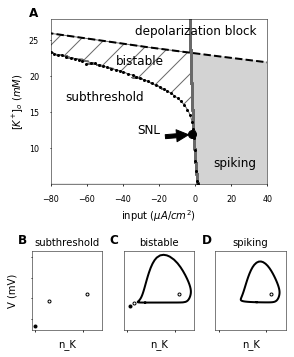

In [26]:
###################################
### Plot bifurcation diagram with phase planes ######
###################################
### Importing the format for figures..
import json
P= json.load(open("cfg/PLOSmpl.json")) # import plot parameter
matplotlib.rcParams.update([(j,k) for (j,k) in P.items()
                            if j in matplotlib.rcParams.keys()])

plt.close("all")
fig_wide=matplotlib.rcParams["figure.figsize"][0]
fig_height=matplotlib.rcParams["figure.figsize"][1]
fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height*1.3))
axpl = plt.subplot2grid((48,16), (0, 2), colspan=12,rowspan=25)
ax1l = plt.subplot2grid((48,16), (35, 1), colspan=4,rowspan=12)
ax1m = plt.subplot2grid((48,16), (35, 6), colspan=4,rowspan=12,sharex=ax1l,sharey=ax1l)
ax1r = plt.subplot2grid((48,16), (35, 11), colspan=4,rowspan=12,sharex=ax1l,sharey=ax1l)


xlim=[-80,40]
ylim=[5.1,28]
axpl.set_xlim(xlim)
axpl.set_ylim(ylim)

s_x=1;s_y=0
##### plot saddle node bifurcation, hopf and limit cycle onset
nss=20
axpl.plot(m_res_par_sn_KoIapp[s_x][::nss],m_res_par_sn_KoIapp[s_y][::nss],'o',markersize=2,color='dimgray')
axpl.plot(m_res_par_lc_KoIapp[s_x][::nss],m_res_par_lc_KoIapp[s_y][::nss],'o',markersize=2,color=[0,0,0])
axpl.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',color=[0,0,0])

##### Fill the different regions
a=m_res_par_lc_KoIapp[s_x]
b=m_res_par_sn_KoIapp[s_y]
bx=m_res_par_sn_KoIapp[s_x]
c=m_res_par_HF0[s_x]
cy=m_res_par_HF0[s_y]
f1x = interp1d(m_res_par_sn_KoIapp[s_y][bx.argsort()],bx[bx.argsort()],fill_value=min(m_res_par_sn_KoIapp[s_x]), bounds_error=False)
f2x = interp1d(m_res_par_lc_KoIapp[s_y][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
f3x = interp1d(m_res_par_HF0[s_y][c.argsort()],c[c.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
yy=m_res_par_sn_KoIapp[s_x][b.argsort()]
yy2=np.minimum(f3x(b[b.argsort()]),yy)
axpl.fill_betweenx(b[b.argsort()],f2x(b[b.argsort()]),yy2,facecolor="none",hatch="/", edgecolor='dimgray')
cc=[i for i in b.argsort() if f3x(b[i])>f1x(b[i])]
axpl.fill_betweenx(b[cc],f1x(b[cc]),f3x(b[cc]),color='lightgrey',rasterized=True)

## Finding Co-dimension2 bifurcation
snl_ko=b[b.argsort()][np.nonzero(f2x(b[b.argsort()])>=m_res_par_sn_KoIapp[s_x][b.argsort()])][-2]
snl_iapp=bx[bx.argsort()][np.nonzero(f2x(b[b.argsort()])>=m_res_par_sn_KoIapp[s_x][b.argsort()])][-2]
axpl.plot(snl_iapp,snl_ko,'o',markersize=8,color='black')

txt0='SNL'
axpl.annotate(txt0, (snl_iapp,snl_ko),xytext=(0.4, 0.3), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.1))

##### Naming the different regions
axpl.annotate('bistable', (snl_iapp,snl_ko),xytext=(0.3,0.72), textcoords='axes fraction')
axpl.annotate('spiking', (snl_iapp,snl_ko),xytext=(0.75,0.1), textcoords='axes fraction')
axpl.annotate('subthreshold', (snl_iapp,snl_ko),xytext=(0.07,0.5), textcoords='axes fraction')
axpl.annotate('depolarization block', (snl_iapp,snl_ko),xytext=(0.39,0.9), textcoords='axes fraction')

##### Plot axes
axpl.set_ylabel('${[K^{+}]}_o$ $(mM)$')
axpl.set_xlabel('input $(\mu A/cm^2)$')
axpl.tick_params(axis='y', pad=10)
axpl.tick_params(axis='x', pad=10)



## Phase planes
ax=[ax1l,ax1m,ax1r]
t_I_app_specf_temp_ii=range(len(t_I_app_specf))
###### Plotting phase planes
for ii_iapi_ax,ii_iapi in enumerate(t_I_app_specf_temp_ii):
    st_lc=[]
    us_lc=[]
    ### Plot nodes
    for ss_Iapp,ss_stab in zip(ss_I_app_specf,ss_stabs):
        # check if the current is similar to the specified current
        if abs(ss_Iapp[strIapp]-t_I_app_specf[ii_iapi])<1*10**-3:
            # check stability
            if ss_stab<0:
                ax[ii_iapi_ax].plot(ss_Iapp[unames[2]],ss_Iapp['v'],'o',markersize=3,color='black')
            else:
                ax[ii_iapi_ax].plot(ss_Iapp[unames[2]],ss_Iapp['v'],'o',markersize=3,mfc='none',color='black')

    # plot limit cycles.
    for lcIapp,lc_stab in zip(lc_Iapp_specf,lc_stabs):
        # check if the current is similar to the specified current
        if lc_stab is not None and abs(lcIapp[strIapp]-t_I_app_specf[ii_iapi])<1*10**-3:
            # check stability
            if lc_stab<0:
                ax[ii_iapi_ax].plot(lcIapp[unames[2]],lcIapp['v'],color='black')
            else:
                ax[ii_iapi_ax].plot(lcIapp[unames[2]],lcIapp['v'],'--',dashes=(4, 5),color='black')
    

    ### Defining axes            
    ax[ii_iapi_ax].set_xlabel(unames[2])
    ax[ii_iapi_ax].set_ylabel('V(mV)')
    

ax1l.set_ylabel('V (mV)', labelpad=10)
ax1l.set_yticklabels([])

ax1m.get_yaxis().set_visible(False)
ax1r.get_yaxis().set_visible(False)

ax1l.set_xticklabels([])
ax1m.set_xticklabels([])
ax1r.set_xticklabels([])

### Naming phase planes
ax1l.set_title('subthreshold',fontsize=matplotlib.rcParams["axes.labelsize"])
ax1m.set_title('bistable',fontsize=matplotlib.rcParams["axes.labelsize"])
ax1r.set_title('spiking',fontsize=matplotlib.rcParams["axes.labelsize"])

### Including tags
ax_4tag=[axpl,ax1l,ax1m,ax1r]
import string
for n, axs in enumerate(ax_4tag):
    if n==0:
        axs.text(-0.1, 1.01, string.ascii_uppercase[n], transform=axs.transAxes, 
                size=12, fontweight='bold')
    if n==1 or n==2 or n==3:
        axs.text(-0.2, 1.1, string.ascii_uppercase[n], transform=axs.transAxes, 
                size=12, fontweight='bold')



plt.show()
